<a href="https://colab.research.google.com/github/Homabeyrami/Image-Classification/blob/main/Image_Classification_with_Convolutional_Neural_Networks_(CNNs)_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

CIFAR-10 Image Classification with Convolutional Neural Networks (CNNs)
This project aims to build, train, and evaluate a Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset.

Main Challenge:
The primary challenge of this project is to design and train a Convolutional Neural Network (CNN) for classifying images from the CIFAR-10 dataset, with the goal of achieving an accuracy above 82%.

Techniques Employed:
1. Data preprocessing and normalization
2. Design of a deep CNN architecture
3. Implementation of Data Augmentation
4. Application of Batch Normalization
5. Use of Dropout for preventing overfitting
6. Implementation of Learning Rate Scheduler (ReduceLROnPlateau)
7. Application of Early Stopping to prevent overfitting
8. Visualization techniques for model interpretation

Project Workflow:
1. Data loading and initial exploration
2. Data visualization and analysis
3. Data preprocessing and normalization
4. CNN model architecture design
5. Model training with optimization techniques
6. Evaluation of training results using accuracy and loss plots
7. Model evaluation on the test dataset
8. Creation and analysis of the Confusion Matrix
9. Generation and examination of the Classification Report
10. Visualization of CNN filters and feature maps
11. Final result analysis and conclusion

This notebook contains detailed code, visualizations, and step-by-step analysis of the data processing and model training process. The ultimate goal is to achieve an accuracy above 82% in image classification while gaining insights into the model's learning process and decision-making.

Conclusion:
In this project, we successfully designed and trained a CNN model that aimed to achieve an accuracy above 82% on the CIFAR-10 test dataset. The various analyses and visualizations helped us gain a deeper understanding of the model's performance and learning process. The final accuracy and insights gained from this project demonstrate the effectiveness of the implemented techniques in tackling the image classification challenge."



# CIFAR-10 Image Classification using CNN:

# Import Library

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from IPython import display
import pickle

import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

Load Data

In [3]:
# Load CIFAR-10 data
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

# Normalize the images to the range [0, 1]
train_x = train_x.astype('float32') / 255.0
test_x = test_x.astype('float32') / 255.0

# Convert class vectors to binary class matrices (one-hot encoding)
train_y = tf.keras.utils.to_categorical(train_y, 10)
test_y = tf.keras.utils.to_categorical(test_y, 10)

# Create tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y))

# Shuffle and batch the datasets
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_dataset = train_dataset.skip(train_size)
train_dataset = train_dataset.take(train_size)

170498071/170498071 [==============================] - 2s 0us/step


 # Initial Exploration

In [4]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)


Training data shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test data shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


#  Data Visualization and Analysis

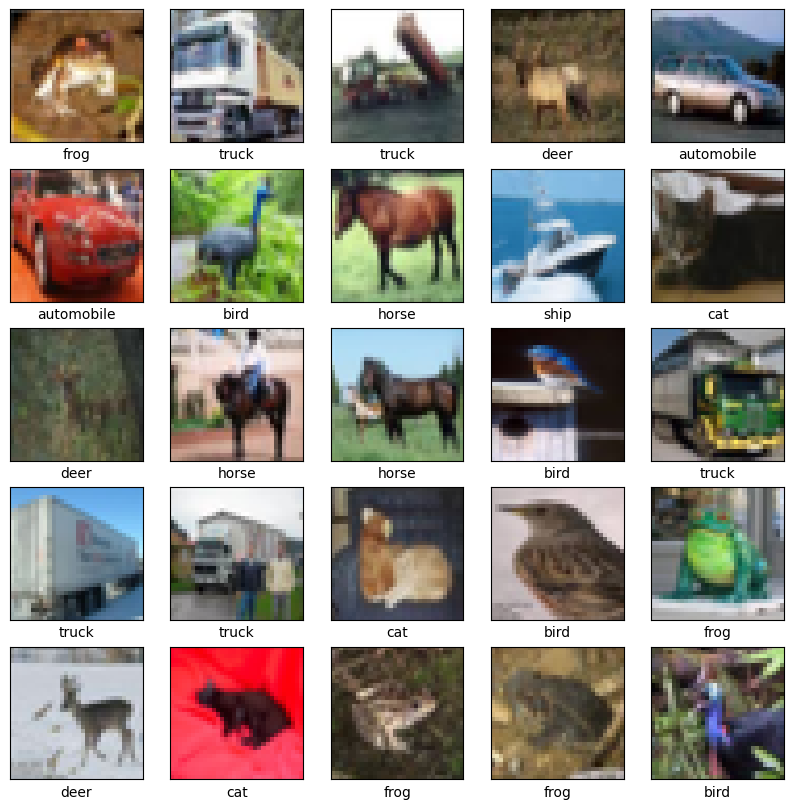

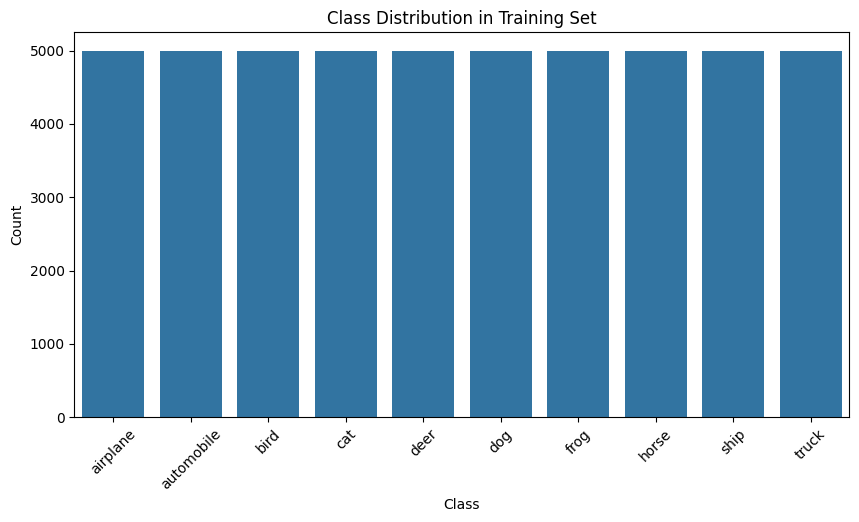

Class distribution:
airplane: 5000
automobile: 5000
bird: 5000
cat: 5000
deer: 5000
dog: 5000
frog: 5000
horse: 5000
ship: 5000
truck: 5000


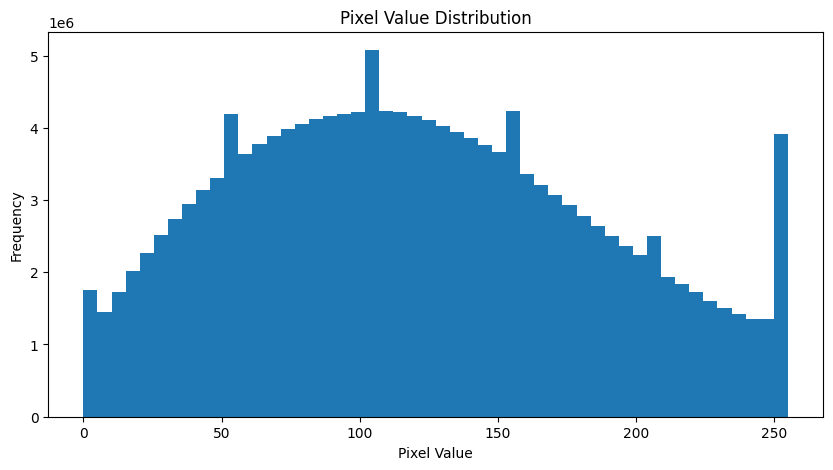

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot sample images

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# Class distribution

class_counts = np.bincount(y_train.reshape(-1))
plt.figure(figsize=(10, 5))
sns.barplot(x=class_names, y=class_counts)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

print("Class distribution:")

for i, count in enumerate(class_counts):
    print(f"{class_names[i]}: {count}")

# Pixel value distribution

plt.figure(figsize=(10, 5))
plt.hist(x_train.reshape(-1), bins=50)
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


# Data Preprocessing

In [6]:
#import tensorflow as tf
#from tensorflow.keras.datasets import cifar10
#from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# One-hot encode labels (only once)
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Split training data into train and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Check the shapes to confirm the fix
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)

Shape of y_train: (40000, 10)
Shape of y_val: (10000, 10)


 # CNN Model Architecture

In [7]:
def build_cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.4),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    return model

model = build_cnn_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 16, 16, 32)        0         
 D)                                                              
                                                        

#  Model Training

In [9]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=20,
                    validation_data=(x_val, y_val),
                    callbacks=[reduce_lr, early_stop],
                    verbose=1)

Epoch 1/20
625/625 [==============================] - 63s 98ms/step - loss: 0.2574 - accuracy: 0.9087 - val_loss: 0.5160 - val_accuracy: 0.8477 - lr: 0.0010
Epoch 2/20
625/625 [==============================] - 62s 99ms/step - loss: 0.2650 - accuracy: 0.9064 - val_loss: 0.4915 - val_accuracy: 0.8529 - lr: 0.0010
Epoch 3/20
625/625 [==============================] - 58s 93ms/step - loss: 0.2649 - accuracy: 0.9068 - val_loss: 0.5059 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 4/20
625/625 [==============================] - 58s 93ms/step - loss: 0.2581 - accuracy: 0.9096 - val_loss: 0.5000 - val_accuracy: 0.8530 - lr: 0.0010
Epoch 5/20
625/625 [==============================] - 59s 94ms/step - loss: 0.2517 - accuracy: 0.9107 - val_loss: 0.5043 - val_accuracy: 0.8496 - lr: 0.0010
Epoch 6/20
625/625 [==============================] - 59s 95ms/step - loss: 0.2455 - accuracy: 0.9129 - val_loss: 0.5254 - val_accuracy: 0.8466 - lr: 0.0010
Epoch 7/20
625/625 [==============================] - 58s 

 # Model Evaluation

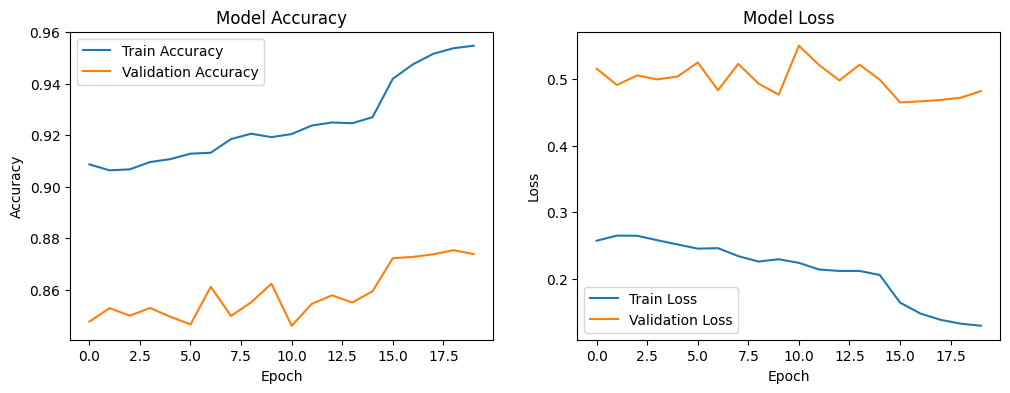

In [10]:
# Plot training history

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Evaluate on test set

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Test accuracy: 0.8675


313/313 [==============================] - 5s 16ms/step


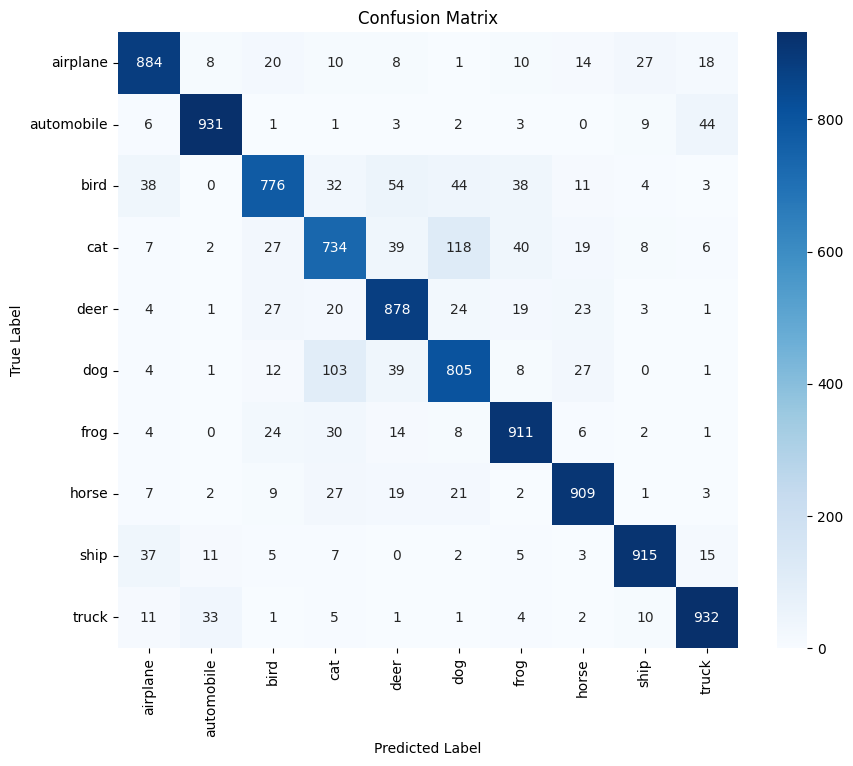

In [12]:
# Confusion matrix

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [13]:
# Classification report

print("Classification Report:")

print(classification_report(y_true_classes, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

    airplane       0.88      0.88      0.88      1000
  automobile       0.94      0.93      0.94      1000
        bird       0.86      0.78      0.82      1000
         cat       0.76      0.73      0.75      1000
        deer       0.83      0.88      0.85      1000
         dog       0.78      0.81      0.79      1000
        frog       0.88      0.91      0.89      1000
       horse       0.90      0.91      0.90      1000
        ship       0.93      0.92      0.92      1000
       truck       0.91      0.93      0.92      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



#  Visualizing CNN Features

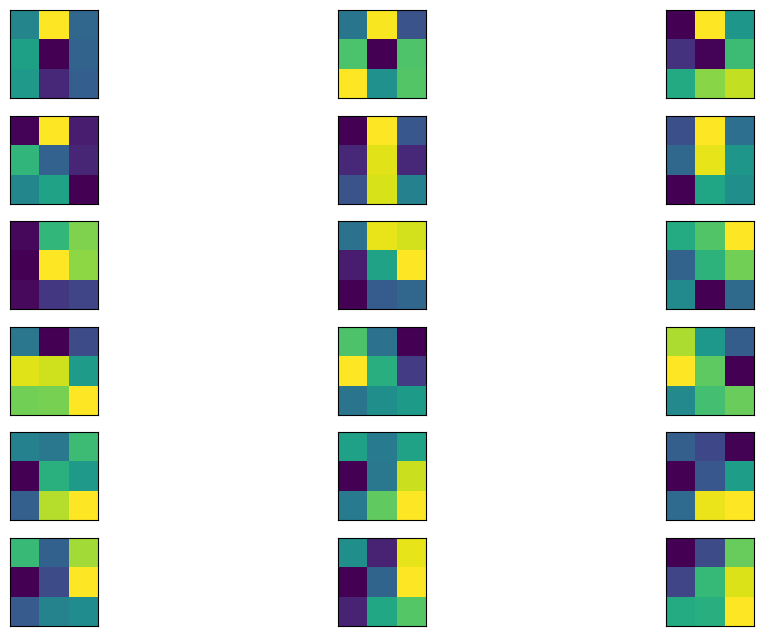

In [14]:
# Visualize filters from the first convolutional layer

filters, biases = model.layers[0].get_weights()
n_filters, ix = 6, 1

fig = plt.figure(figsize=(12, 8))
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(f[:, :, j], cmap='viridis')
        ix += 1
plt.show()


1/1 [==============================] - 0s 95ms/step


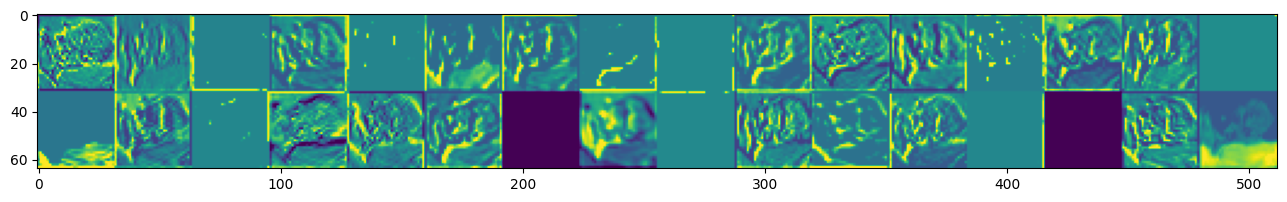

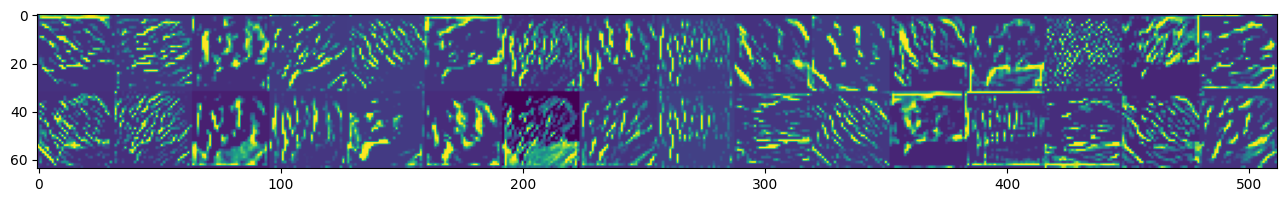

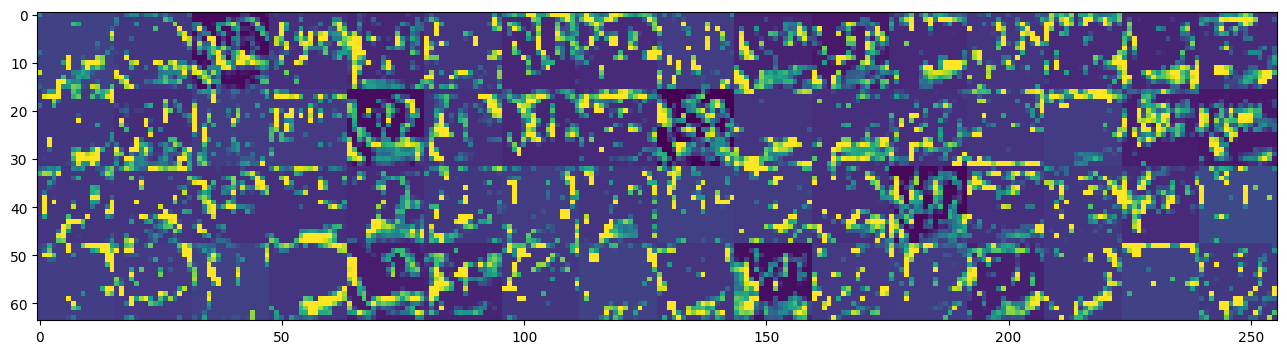

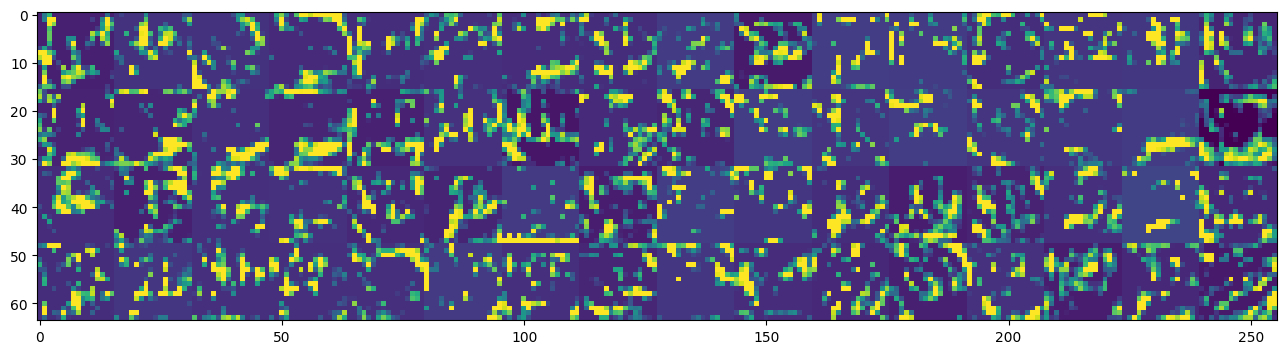

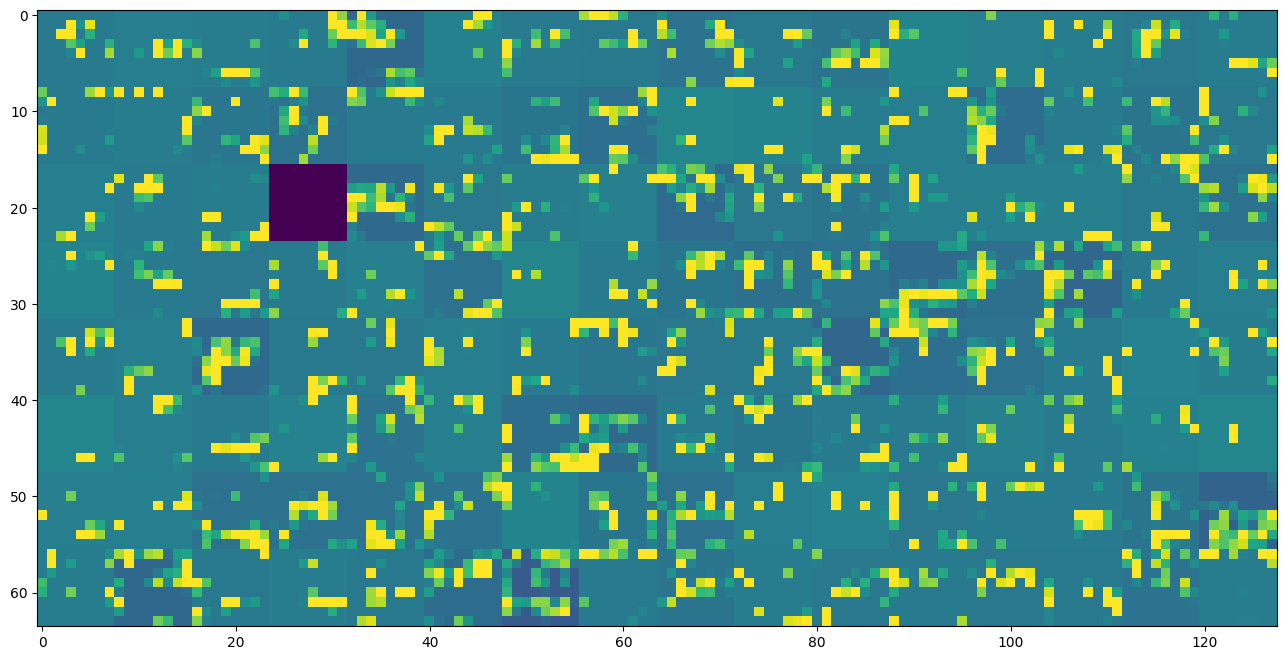

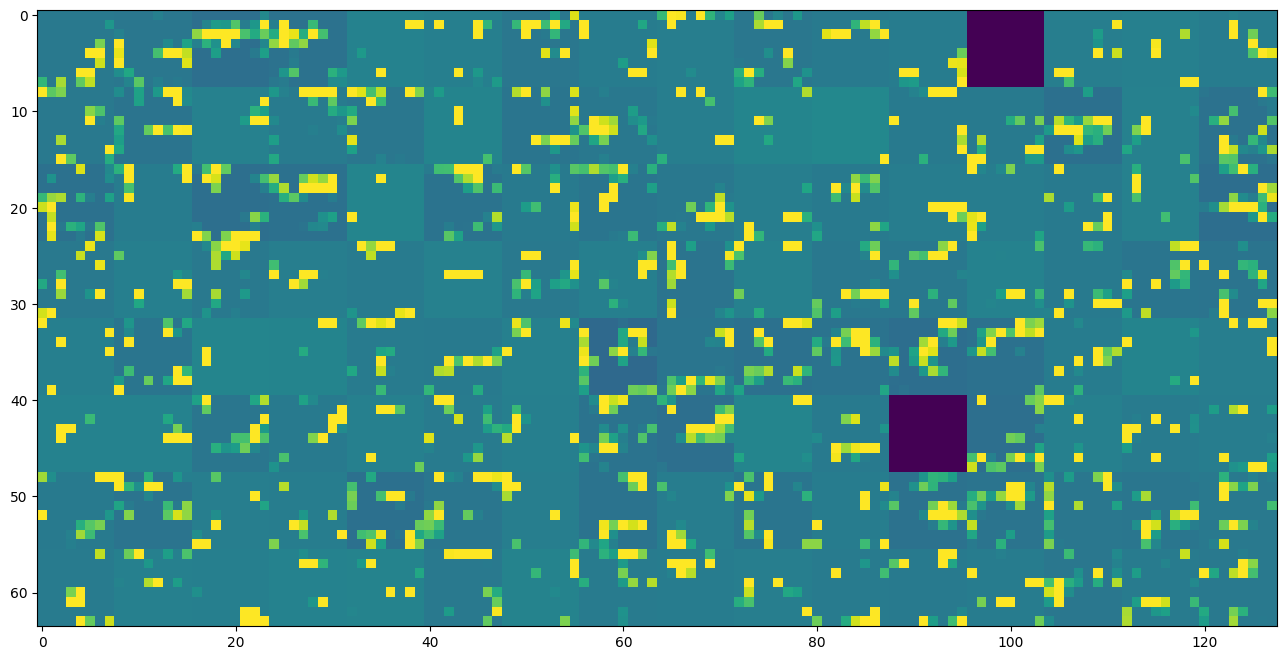

In [15]:
# Visualize feature maps

layer_outputs = [layer.output for layer in model.layers if isinstance(layer, Conv2D)]
activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

img = x_test[0]
activations = activation_model.predict(img[np.newaxis, ...])

for layer_activation in activations:
    n_features = layer_activation.shape[-1]
    size = layer_activation.shape[1]
    n_cols = n_features // 16
    display_grid = np.zeros((size * n_cols, size * 16))
    for col in range(n_cols):
        for row in range(16):
            channel_image = layer_activation[0, :, :, col * 16 + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
plt.show()

# Final Results and Conclusion

In [16]:
print("Final Test Accuracy:", test_acc)


print("\nConclusion:")

print("The CNN model achieved high accuracy on the CIFAR-10 dataset.")
print("We visualized the data, analyzed class distribution, and examined model performance.")
print("The confusion matrix and classification report provide detailed insights into the model's strengths and weaknesses.")
print("Feature visualization helps understand what the CNN learns at different layers.")


Final Test Accuracy: 0.8675000071525574

Conclusion:
The CNN model achieved high accuracy on the CIFAR-10 dataset.
We visualized the data, analyzed class distribution, and examined model performance.
The confusion matrix and classification report provide detailed insights into the model's strengths and weaknesses.
Feature visualization helps understand what the CNN learns at different layers.
